In [2]:
from spacy.lang.pl import STOP_WORDS
from tqdm import tqdm
from spacy import Language
import numpy as np
import pandas as pd

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

import spacy

df_facebook = pd.read_csv('data_facebook/facebook_data.csv')

nlp= spacy.load("pl_core_news_lg")

# My list of stop words.
stop_list = ["móc", "mieć", "  ", "   ", "    ", "     ", "      ", "       ", "chcieć", "problem", "xd", "jakieś", "siema", "wiedzieć", "robić", "zrobić", "mówić", "pytanie"]

#rok, dziewczyna

# Updates spaCy's default stop words list with my additional words.
nlp.Defaults.stop_words.update(stop_list)

# Iterates over the words in the stop words list and resets the "is_stop" flag.
for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True

@Language.component("my_lemmatizer")
def lemmatizer(doc):
    # This takes in a doc of tokens from the NER and lemmatizes them.
    # Pronouns (like "I" and "you" get lemmatized to '-PRON-', so I'm removing those.
    doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    doc = u' '.join(doc)
    return nlp.make_doc(doc)

@Language.component("my_stopwords")
def remove_stopwords(doc):
    # This will remove stopwords and punctuation.
    # Use token.text to return strings, which we'll need for Gensim.
    doc = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
    return doc

# The add_pipe function appends our functions to the default pipeline.
nlp.add_pipe("my_lemmatizer",after='ner')
nlp.add_pipe("my_stopwords", last=True)


doc_list = []
# Iterates through each article in the corpus.
for doc in tqdm(df_facebook['POSTS']):
    # Passes that article through the pipeline and adds to a new list.
    pr = nlp(doc)
    doc_list.append(pr)

doc_list[4]

100%|██████████| 539/539 [00:22<00:00, 23.84it/s]


['skilla',
 'nabyć',
 'bliski',
 'przyszłość',
 'typ',
 'nauczyć',
 'chodzić',
 'ręka',
 'itp',
 'szukać',
 'jakiejś',
 'inspiracja']

In [3]:
# Creates, which is a mapping of word IDs to words.
words = corpora.Dictionary(doc_list)

# Turns each document into a bag of words.
corpus = [words.doc2bow(doc) for doc in doc_list]

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=words,
                                            num_topics=3,
                                            random_state=2,
                                            update_every=1,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

print(lda_model.print_topics(num_words=10))

[(0, '0.004*"czas" + 0.004*"dziewczyna" + 0.003*"temat" + 0.003*"polecać" + 0.003*"kobieta" + 0.003*"rok" + 0.003*"szukać" + 0.003*"wyglądać" + 0.002*"chodzić" + 0.002*"rada"'), (1, '0.012*"czas" + 0.009*"rok" + 0.008*"dziewczyna" + 0.006*"zacząć" + 0.006*"pisać" + 0.005*"powiedzieć" + 0.005*"czuć" + 0.005*"sytuacja" + 0.004*"dzień" + 0.004*"związka"'), (2, '0.007*"dziewczyna" + 0.007*"czas" + 0.006*"praca" + 0.005*"rok" + 0.004*"chłopak" + 0.004*"sytuacja" + 0.003*"życie" + 0.003*"zacząć" + 0.003*"czuć" + 0.003*"temat"')]


(1, 0.9932232)
(0, 0.99504566)
(1, 0.9922719)
(2, 0.9963078)
(0, 0.9877371)
(0, 0.9894649)
(0, 0.99586785)
(1, 0.9892282)
(2, 0.99724525)
(0, 0.9959791)
(0, 0.9940631)
(0, 0.99381775)
(0, 0.9929421)
(1, 0.99277914)
(1, 0.99505806)
(0, 0.9792191)
(1, 0.99881005)
(2, 0.9963076)
(2, 0.9963079)
(1, 0.9948207)
(1, 0.99814653)
(0, 0.9837368)
(2, 0.99533063)
(0, 0.9960836)
(0, 0.9907656)
(1, 0.9866119)
(1, 0.017408967)
(1, 0.9910037)
(1, 0.9956434)
(2, 0.98616815)
(1, 0.99864835)
(1, 0.9969681)
(0, 0.97921824)
(1, 0.99624175)
(1, 0.9975726)
(1, 0.99564475)
(2, 0.99630755)
(2, 0.99417055)
(2, 0.9951705)
(1, 0.99793655)
(0, 0.99747336)
(1, 0.9939718)
(2, 0.99072117)
(1, 0.9974003)
(1, 0.99624044)
(1, 0.99546546)
(1, 0.98807824)
(0, 0.99355245)
(0, 0.99562603)
(2, 0.9933448)
(2, 0.9874024)
(1, 0.011037537)
(0, 0.9990889)
(2, 0.9948142)
(0, 0.99549466)
(2, 0.9971338)
(2, 0.9962078)
(1, 0.9959657)
(1, 0.01256789)
(2, 0.98467153)
(0, 0.27077532)
(1, 0.9952666)
(0, 0.99178123)
(1, 0.9963647)
(1, 0.9

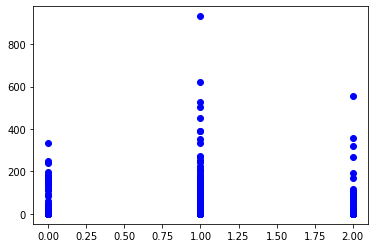

In [5]:
import matplotlib.pyplot as plt

corpus_transformed = lda_model[corpus]

for elem in corpus_transformed:
    print(elem[0][0])

x_topic = []
y_topic_react = []

for i in range(len(df_facebook['POSTS'])):
    x_topic.append(corpus_transformed[i][0][0][0])
    y_topic_react.append(int(df_facebook['ALL_REACTIONS'][i]))

x_topic_array = np.array(x_topic)
y_topic_react_array = np.array(y_topic_react)
plt.plot(x_topic_array, y_topic_react_array, 'bo')
plt.show()

(1, 0.99575776)
(0, 0.9963964)
(1, 0.9951612)
(0, 0.99715203)
(0, 0.9910712)
(0, 0.9923313)
(0, 0.9969956)
(0, 0.9893172)
(1, 0.9986597)
(0, 0.997076)
(0, 0.99568146)
(0, 0.9955035)
(0, 0.9948662)
(0, 0.9928369)
(1, 0.9969074)
(0, 0.9848496)
(1, 0.99925596)
(0, 0.84062934)
(1, 0.99820364)
(1, 0.9967587)
(1, 0.9988409)
(0, 0.9881482)
(0, 0.99639744)
(0, 0.99715257)
(0, 0.99328023)
(0, 0.9867021)
(0, 0.9789947)
(1, 0.9943657)
(1, 0.9972738)
(0, 0.98931295)
(0, 0.73041975)
(1, 0.99810356)
(0, 0.9848493)
(1, 0.9976487)
(1, 0.9984818)
(0, 0.9956807)
(0, 0.997152)
(0, 0.51889926)
(0, 0.9962745)
(1, 0.9987095)
(0, 0.99816316)
(1, 0.99622697)
(1, 0.99547964)
(1, 0.9983739)
(1, 0.99764806)
(1, 0.99716264)
(1, 0.99252903)
(0, 0.99530786)
(0, 0.9968192)
(1, 0.9967583)
(1, 0.9938621)
(0, 0.9867039)
(0, 0.9993376)
(0, 0.9959989)
(0, 0.9967232)
(0, 0.99778914)
(0, 0.99707496)
(1, 0.9974759)
(1, 0.9904373)
(1, 0.99252796)
(0, 0.9940196)
(1, 0.99703836)
(0, 0.99401927)
(1, 0.9977257)
(1, 0.99622667)
(

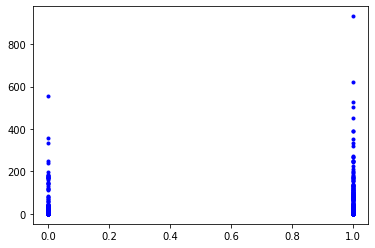

(1, 0.9932232)
(0, 0.99504566)
(1, 0.9922719)
(2, 0.9963078)
(0, 0.9877371)
(0, 0.98946494)
(0, 0.99586785)
(1, 0.9892282)
(2, 0.9972452)
(0, 0.9959791)
(0, 0.9940631)
(0, 0.9938177)
(0, 0.9929421)
(1, 0.99277914)
(1, 0.99505806)
(0, 0.9792191)
(1, 0.99881005)
(2, 0.9963076)
(2, 0.99630785)
(1, 0.9948207)
(1, 0.99814653)
(0, 0.9837368)
(2, 0.99533063)
(0, 0.9960836)
(0, 0.9907656)
(1, 0.9866119)
(1, 0.017408969)
(1, 0.9910037)
(1, 0.9956434)
(2, 0.98616815)
(1, 0.99864835)
(1, 0.9969681)
(0, 0.97921824)
(1, 0.99624175)
(1, 0.9975726)
(1, 0.99564475)
(2, 0.99630755)
(2, 0.9941706)
(2, 0.9951705)
(1, 0.99793655)
(0, 0.99747336)
(1, 0.9939718)
(2, 0.9907211)
(1, 0.9974003)
(1, 0.99624044)
(1, 0.99546546)
(1, 0.98807824)
(0, 0.99355245)
(0, 0.99562603)
(2, 0.9933448)
(2, 0.9874024)
(1, 0.011037524)
(0, 0.9990889)
(2, 0.9948142)
(0, 0.99549466)
(2, 0.9971338)
(2, 0.9962078)
(1, 0.9959657)
(1, 0.012567889)
(2, 0.98467153)
(0, 0.27079043)
(1, 0.9952666)
(0, 0.99178123)
(1, 0.9963647)
(1, 0.99

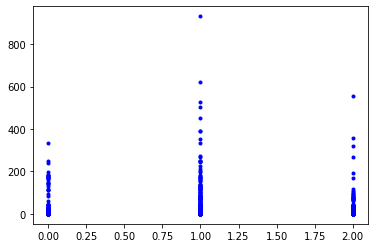

(3, 0.9897932)
(0, 0.99349564)
(3, 0.9883626)
(2, 0.9949843)
(0, 0.98393506)
(0, 0.98619056)
(0, 0.29165253)
(3, 0.98380446)
(3, 0.99676615)
(0, 0.9947197)
(0, 0.9922078)
(0, 0.9918861)
(0, 0.9907397)
(0, 0.9870966)
(1, 0.9922183)
(0, 0.9728391)
(1, 0.99812347)
(2, 0.9949839)
(3, 0.9956671)
(1, 0.99184656)
(1, 0.99707806)
(0, 0.97871816)
(2, 0.9936582)
(0, 0.9948569)
(0, 0.9878859)
(3, 0.97989166)
(1, 0.013231002)
(1, 0.98585844)
(1, 0.9931394)
(2, 0.9812698)
(3, 0.9979598)
(1, 0.99522275)
(0, 0.97284025)
(3, 0.9943327)
(1, 0.99617416)
(1, 0.99314094)
(2, 0.9949839)
(2, 0.99208635)
(3, 0.9943339)
(1, 0.9967476)
(3, 0.99720323)
(3, 0.9909156)
(2, 0.98741513)
(1, 0.99590266)
(1, 0.99407834)
(1, 0.9928583)
(3, 0.9820773)
(0, 0.706764)
(0, 0.99425656)
(2, 0.99096835)
(2, 0.9829351)
(2, 0.97672206)
(0, 0.9988025)
(2, 0.9929589)
(0, 0.99408436)
(3, 0.9966357)
(2, 0.9948488)
(1, 0.9936453)
(2, 0.97351176)
(2, 0.97924936)
(3, 0.99091285)
(1, 0.99254817)
(3, 0.9909161)
(1, 0.9942737)
(1, 0.9905

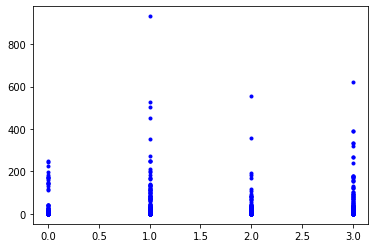

(3, 0.9873562)
(1, 0.9928289)
(3, 0.98558897)
(4, 0.9935987)
(0, 0.9803366)
(0, 0.9830893)
(0, 0.3578161)
(0, 0.9765087)
(3, 0.99598676)
(0, 0.99352145)
(3, 0.99185455)
(0, 0.9900515)
(0, 0.98864865)
(1, 0.98579484)
(1, 0.99025965)
(3, 0.011092236)
(1, 0.9976475)
(2, 0.9938145)
(3, 0.9946247)
(3, 0.9903249)
(1, 0.9963381)
(0, 0.9739828)
(2, 0.6633664)
(4, 0.9935984)
(0, 0.3654679)
(3, 0.97515446)
(0, 0.95429087)
(1, 0.9823278)
(1, 0.99141103)
(4, 0.9761708)
(1, 0.9973286)
(1, 0.9940159)
(0, 0.9668405)
(1, 0.9925859)
(1, 0.9952065)
(4, 0.99030674)
(2, 0.9938143)
(2, 0.9902478)
(3, 0.99297285)
(1, 0.9959244)
(3, 0.9965288)
(1, 0.5783508)
(2, 0.98450774)
(1, 0.99486667)
(1, 0.9925847)
(1, 0.9910598)
(1, 0.97662383)
(0, 0.78020996)
(1, 0.99366766)
(2, 0.98887306)
(2, 0.979016)
(2, 0.9714173)
(0, 0.9985294)
(4, 0.9910178)
(0, 0.9927429)
(3, 0.995825)
(2, 0.9936481)
(1, 0.9920428)
(2, 0.9674955)
(3, 0.9778409)
(3, 0.98873955)
(4, 0.9894742)
(3, 0.9887441)
(1, 0.992829)
(1, 0.9881272)
(0, 0.2

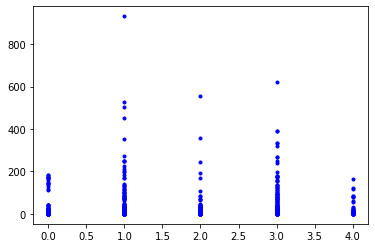

(3, 0.98508793)
(1, 0.99158067)
(1, 0.982175)
(4, 0.9927011)
(0, 0.9777214)
(5, 0.9815513)
(3, 0.99330235)
(3, 0.97640514)
(3, 0.99526036)
(0, 0.9926472)
(3, 0.9903874)
(0, 0.98871434)
(0, 0.9871255)
(0, 0.98208374)
(1, 0.9885671)
(3, 0.010215241)
(5, 0.9971386)
(2, 0.99287647)
(3, 0.9936527)
(3, 0.9885836)
(1, 0.99569815)
(0, 0.9705466)
(2, 0.54714435)
(4, 0.992701)
(0, 0.9831823)
(3, 0.9707526)
(0, 0.94838685)
(1, 0.9792801)
(5, 0.9895636)
(4, 0.9728916)
(5, 0.9967508)
(5, 0.9927258)
(0, 0.9624968)
(0, 0.63900113)
(1, 0.99436957)
(4, 0.9889524)
(2, 0.99287635)
(2, 0.9887745)
(3, 0.9917049)
(1, 0.9952127)
(3, 0.99590015)
(1, 0.9860701)
(2, 0.98218024)
(1, 0.99397075)
(1, 0.9912936)
(1, 0.9895049)
(1, 0.9726157)
(5, 0.9886705)
(5, 0.99230236)
(2, 0.98719424)
(2, 0.97588044)
(5, 0.9682302)
(0, 0.9983298)
(2, 0.99000806)
(0, 0.9917644)
(3, 0.99506927)
(2, 0.99268514)
(1, 0.99065816)
(2, 0.9626972)
(3, 0.9739018)
(3, 0.9867184)
(5, 0.98866737)
(3, 0.9867214)
(1, 0.99158037)
(1, 0.98606825

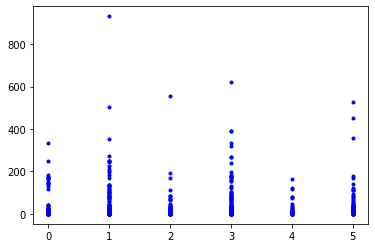

(3, 0.98249805)
(0, 0.98977536)
(6, 0.9798468)
(4, 0.9918655)
(6, 0.97658527)
(0, 0.978376)
(3, 0.99213016)
(3, 0.9723419)
(3, 0.9944298)
(0, 0.99169314)
(0, 0.9877592)
(0, 0.752141)
(6, 0.9864522)
(6, 0.9811601)
(1, 0.9869453)
(0, 0.9577744)
(5, 0.9967717)
(2, 0.5770825)
(6, 0.99246025)
(3, 0.98659676)
(1, 0.9950835)
(2, 0.96720356)
(2, 0.5140971)
(0, 0.9919087)
(0, 0.3981787)
(3, 0.96573627)
(1, 0.010701358)
(6, 0.976585)
(6, 0.98859024)
(2, 0.97037387)
(5, 0.9963344)
(6, 0.9920447)
(0, 0.9577757)
(1, 0.99005675)
(1, 0.9935662)
(5, 0.9882364)
(6, 0.9924598)
(2, 0.9874081)
(3, 0.99025565)
(1, 0.9945293)
(3, 0.99518126)
(3, 0.984411)
(2, 0.98002625)
(1, 0.9931108)
(6, 0.9901466)
(6, 0.9881251)
(1, 0.96879154)
(0, 0.4817545)
(5, 0.9913203)
(2, 0.9856382)
(2, 0.9729838)
(6, 0.9653601)
(0, 0.99811196)
(2, 0.9887899)
(6, 0.99133116)
(3, 0.99420524)
(2, 0.99179095)
(1, 0.9893302)
(6, 0.9606458)
(2, 0.96721035)
(3, 0.98440766)
(5, 0.9872267)
(3, 0.98441124)
(1, 0.9903831)
(1, 0.98409796)
(3,

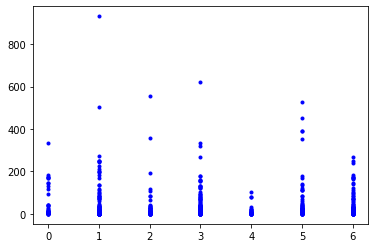

(3, 0.98064363)
(7, 0.9892678)
(3, 0.977958)
(7, 0.99150616)
(6, 0.97364867)
(1, 0.30560404)
(3, 0.9912877)
(3, 0.96944094)
(3, 0.9938322)
(0, 0.99082875)
(3, 0.98750514)
(0, 0.9859364)
(6, 0.9847388)
(0, 0.9777065)
(1, 0.98549634)
(5, 0.9547492)
(5, 0.99638623)
(2, 0.9911255)
(3, 0.99174356)
(3, 0.98516965)
(1, 0.9945336)
(0, 0.96344405)
(2, 0.4885719)
(4, 0.9910909)
(0, 0.28016353)
(4, 0.95919275)
(1, 0.010117954)
(1, 0.9737749)
(6, 0.98714435)
(2, 0.9671818)
(5, 0.9958973)
(5, 0.102608986)
(0, 0.9535352)
(0, 0.98833007)
(1, 0.9928475)
(5, 0.9868439)
(6, 0.99150044)
(2, 0.98602873)
(3, 0.98921466)
(1, 0.9939174)
(3, 0.99466383)
(3, 0.9827567)
(2, 0.9778532)
(1, 0.9923415)
(6, 0.9888958)
(6, 0.9866186)
(1, 0.965393)
(3, 0.9864452)
(5, 0.9902896)
(2, 0.9840676)
(2, 0.970066)
(2, 0.9593468)
(7, 0.9980168)
(2, 0.98755974)
(6, 0.990229)
(3, 0.9935837)
(7, 0.9912782)
(1, 0.9881432)
(7, 0.9558201)
(3, 0.96621716)
(6, 0.16643138)
(7, 0.9860549)
(7, 0.982264)
(4, 0.98874426)
(6, 0.9822519)
(7

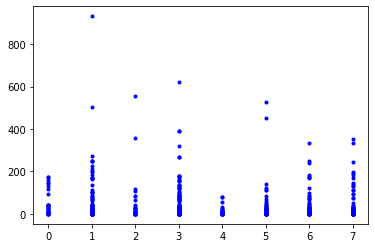

(3, 0.9787317)
(7, 0.988217)
(6, 0.9752483)
(4, 0.9902576)
(6, 0.9712603)
(0, 0.97427005)
(0, 0.3235839)
(3, 0.9664596)
(3, 0.9932143)
(0, 0.99009097)
(3, 0.98626417)
(8, 0.9849431)
(8, 0.9828327)
(1, 0.976825)
(8, 0.9836013)
(5, 0.95079696)
(5, 0.9960561)
(2, 0.55343324)
(3, 0.99091816)
(3, 0.9836981)
(1, 0.99399006)
(1, 0.96204156)
(8, 0.98791456)
(0, 0.99034774)
(0, 0.31259823)
(3, 0.9585024)
(3, 0.011108278)
(1, 0.9712232)
(6, 0.9859618)
(8, 0.9646891)
(5, 0.9955225)
(5, 0.69956946)
(0, 0.94995856)
(7, 0.9878172)
(1, 0.9921377)
(0, 0.9854088)
(6, 0.99071467)
(5, 0.92652833)
(3, 0.98813945)
(1, 0.99331343)
(3, 0.99412876)
(3, 0.98104966)
(2, 0.9757749)
(8, 0.9913351)
(1, 0.9878566)
(6, 0.98538864)
(1, 0.9620539)
(0, 0.74421984)
(5, 0.9894079)
(2, 0.9825629)
(1, 0.9686978)
(6, 0.95758253)
(7, 0.99782085)
(2, 0.98638076)
(8, 0.9890007)
(3, 0.99294096)
(7, 0.9904228)
(8, 0.9865913)
(7, 0.95164126)
(3, 0.9629296)
(3, 0.7409269)
(7, 0.98469317)
(7, 0.9805389)
(8, 0.9879136)
(1, 0.9806039

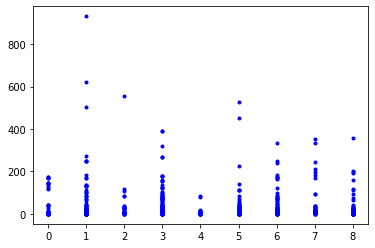

(3, 0.97677237)
(7, 0.987137)
(6, 0.97298425)
(7, 0.9898157)
(9, 0.9679402)
(8, 0.9722216)
(0, 0.36193562)
(0, 0.9612355)
(3, 0.9925802)
(0, 0.9891924)
(7, 0.98460793)
(0, 0.9834416)
(8, 0.9812895)
(6, 0.97473526)
(9, 0.9822285)
(4, 0.94553936)
(5, 0.99569315)
(2, 0.9895164)
(6, 0.989853)
(3, 0.982189)
(1, 0.9935114)
(7, 0.958523)
(8, 0.98682266)
(4, 0.98946035)
(7, 0.97618467)
(3, 0.52203107)
(2, 0.9259097)
(1, 0.9689922)
(6, 0.9846652)
(8, 0.96157485)
(5, 0.99511075)
(5, 0.7772448)
(3, 0.94867724)
(1, 0.986897)
(1, 0.9915128)
(9, 0.98432165)
(3, 0.11122791)
(9, 0.9836805)
(8, 0.9863759)
(1, 0.9927812)
(3, 0.99357945)
(3, 0.9793011)
(2, 0.9738998)
(8, 0.9905493)
(1, 0.98689616)
(6, 0.5594939)
(1, 0.9591453)
(0, 0.9827359)
(5, 0.98844004)
(2, 0.9812023)
(7, 0.96577406)
(6, 0.95377856)
(9, 0.9975745)
(2, 0.49717426)
(8, 0.9880056)
(3, 0.9922813)
(7, 0.9895426)
(8, 0.98538107)
(2, 0.9458325)
(2, 0.9573135)
(8, 0.97824603)
(4, 0.98271495)
(9, 0.97837114)
(8, 0.9868214)
(1, 0.979083)
(7, 0

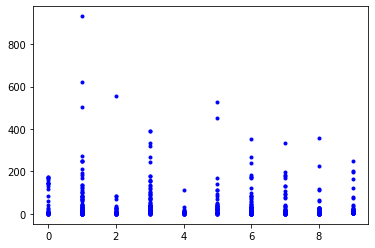

(3, 0.9751324)
(7, 0.98629475)
(6, 0.97130215)
(7, 0.9891469)
(6, 0.96669984)
(8, 0.97034425)
(3, 0.9887753)
(7, 0.96009934)
(3, 0.9920474)
(0, 0.98849237)
(8, 0.98315215)
(0, 0.9823759)
(6, 0.9806581)
(9, 0.9725091)
(9, 0.98107773)
(10, 0.94292265)
(5, 0.9954264)
(2, 0.9888105)
(9, 0.98894775)
(3, 0.9809244)
(1, 0.9930377)
(0, 0.95444566)
(8, 0.98591876)
(4, 0.9887225)
(10, 0.9741225)
(6, 0.95095557)
(3, 0.010289163)
(1, 0.96678317)
(8, 0.9831522)
(8, 0.9590045)
(5, 0.9948083)
(6, 0.98861647)
(7, 0.9440728)
(3, 0.9861079)
(1, 0.9908942)
(9, 0.98330414)
(6, 0.17974417)
(9, 0.9826226)
(3, 0.9861113)
(6, 0.9922353)
(3, 0.99311805)
(3, 0.977834)
(2, 0.97217023)
(8, 0.98989844)
(1, 0.9859456)
(6, 0.9830326)
(1, 0.9562617)
(0, 0.98162526)
(5, 0.98773026)
(2, 0.97994745)
(2, 0.9624589)
(10, 0.9496697)
(7, 0.99746156)
(9, 0.9845206)
(8, 0.98718166)
(3, 0.9917273)
(7, 0.9888563)
(1, 0.5986877)
(10, 0.94292647)
(2, 0.9545301)
(8, 0.9767669)
(5, 0.9819737)
(7, 0.97739154)
(8, 0.9859177)
(1, 0.97

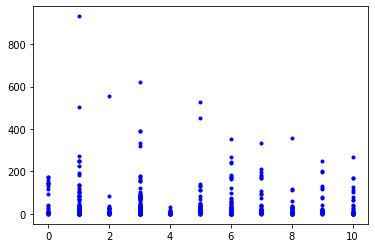

(3, 0.9735958)
(10, 0.98535174)
(6, 0.9697742)
(7, 0.9885665)
(6, 0.57472056)
(0, 0.9687294)
(0, 0.025877697)
(3, 0.95847815)
(3, 0.9842782)
(0, 0.987917)
(7, 0.9827306)
(8, 0.9815502)
(6, 0.9796213)
(6, 0.9717276)
(8, 0.9799116)
(10, 0.94034207)
(5, 0.995204)
(10, 0.9883976)
(9, 0.9883782)
(9, 0.9791806)
(1, 0.42557928)
(9, 0.9528448)
(8, 0.98518217)
(0, 0.9882299)
(0, 0.25377354)
(3, 0.9487038)
(0, 0.91742235)
(6, 0.9649363)
(6, 0.98281956)
(2, 0.956955)
(5, 0.9945557)
(5, 0.98784155)
(0, 0.9394879)
(11, 0.98473036)
(11, 0.990102)
(9, 0.98244923)
(11, 0.98830074)
(9, 0.98173237)
(3, 0.98524326)
(1, 0.99184465)
(3, 0.9926853)
(1, 0.84863865)
(4, 0.97076607)
(11, 0.98940337)
(6, 0.9851513)
(7, 0.98202914)
(1, 0.9540284)
(3, 0.98147124)
(5, 0.9871377)
(2, 0.978993)
(9, 0.9610568)
(6, 0.94840384)
(7, 0.9973247)
(9, 0.98372614)
(8, 0.9865107)
(3, 0.9912077)
(7, 0.9882605)
(8, 0.9835644)
(10, 0.9403452)
(3, 0.9541315)
(6, 0.97631526)
(5, 0.9811085)
(7, 0.9761964)
(8, 0.98518157)
(1, 0.9764

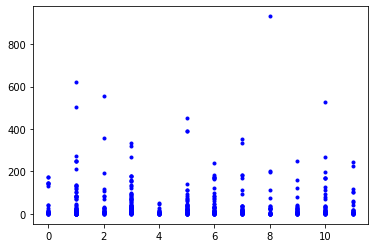

(3, 0.97200155)
(7, 0.87988585)
(3, 0.9681464)
(7, 0.9879518)
(9, 0.9621578)
(8, 0.9673077)
(3, 0.98734206)
(7, 0.95584327)
(3, 0.9910286)
(0, 0.9872447)
(12, 0.9813322)
(8, 0.98064417)
(8, 0.97794414)
(6, 0.9701076)
(9, 0.9789702)
(10, 0.93699646)
(5, 0.9949207)
(3, 0.98799914)
(3, 0.9880004)
(9, 0.9779887)
(1, 0.42776582)
(0, 0.9496856)
(2, 0.45678717)
(4, 0.9875599)
(7, 0.9718927)
(6, 0.94552404)
(6, 0.9158465)
(1, 0.9631285)
(6, 0.9818256)
(8, 0.9548616)
(5, 0.9942344)
(11, 0.986994)
(7, 0.938217)
(11, 0.98390996)
(11, 0.989567)
(0, 0.9812426)
(11, 0.9876696)
(9, 0.9806842)
(8, 0.9839255)
(1, 0.22645202)
(3, 0.9922353)
(1, 0.70545757)
(2, 0.9692786)
(8, 0.9888414)
(12, 0.9838628)
(6, 0.98108554)
(1, 0.95150715)
(0, 0.769929)
(5, 0.986384)
(1, 0.9785506)
(2, 0.9586005)
(12, 0.94403714)
(9, 0.99712205)
(9, 0.9827906)
(8, 0.98584443)
(3, 0.99066746)
(7, 0.98762876)
(8, 0.98275495)
(6, 0.93826884)
(3, 0.951416)
(8, 0.9743707)
(5, 0.98000777)
(7, 0.97493386)
(8, 0.9844505)
(1, 0.9750821

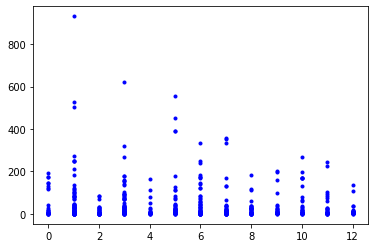

(3, 0.9709231)
(1, 0.8267985)
(13, 0.96619225)
(7, 0.98740536)
(6, 0.9612699)
(8, 0.96582484)
(0, 0.28596705)
(13, 0.9533492)
(3, 0.99067616)
(0, 0.9866967)
(13, 0.9807578)
(2, 0.9796947)
(8, 0.9769344)
(13, 0.9683716)
(9, 0.9779532)
(4, 0.93352485)
(5, 0.4448205)
(2, 0.98707294)
(3, 0.98753065)
(3, 0.97767574)
(1, 0.9918317)
(0, 0.9476085)
(8, 0.9837347)
(0, 0.987041)
(7, 0.9706408)
(6, 0.94310343)
(8, 0.9102063)
(1, 0.9611909)
(8, 0.98054814)
(8, 0.95284206)
(13, 0.993975)
(11, 0.98646504)
(0, 0.93369615)
(11, 0.9832571)
(1, 0.95592433)
(5, 0.9806392)
(6, 0.9874042)
(9, 0.9797489)
(9, 0.98317915)
(6, 0.9909325)
(3, 0.99193)
(3, 0.9740705)
(0, 0.96785)
(11, 0.9883757)
(6, 0.98356354)
(6, 0.98021406)
(1, 0.94898164)
(3, 0.9795809)
(5, 0.98568773)
(2, 0.97686493)
(2, 0.9568025)
(5, 0.9420583)
(7, 0.99705034)
(9, 0.9819555)
(8, 0.98519075)
(3, 0.99030143)
(7, 0.98706836)
(8, 0.98196155)
(6, 0.9355478)
(3, 0.94959646)
(8, 0.97320074)
(4, 0.97872597)
(9, 0.97319216)
(8, 0.9837341)
(6, 0.25

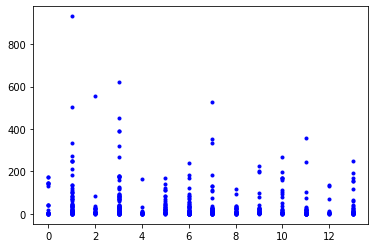

(3, 0.96987987)
(10, 0.98326004)
(14, 0.9644276)
(7, 0.9868427)
(9, 0.959035)
(8, 0.9645902)
(3, 0.986367)
(7, 0.95190716)
(3, 0.9903345)
(14, 0.9862187)
(12, 0.97981197)
(2, 0.97894925)
(11, 0.9761372)
(9, 0.966937)
(9, 0.97720426)
(11, 0.9318782)
(5, 0.9944802)
(2, 0.98659503)
(3, 0.98707616)
(1, 0.97660404)
(1, 0.99153656)
(0, 0.9457954)
(8, 0.98313636)
(4, 0.98656625)
(8, 0.9688676)
(8, 0.93973225)
(13, 0.9079829)
(1, 0.95983183)
(12, 0.9798123)
(12, 0.9511016)
(5, 0.9937353)
(11, 0.9859313)
(13, 0.93236923)
(11, 0.9825988)
(1, 0.9889355)
(13, 0.9800186)
(6, 0.26749706)
(9, 0.9790595)
(14, 0.9824876)
(6, 0.9905594)
(13, 0.9914286)
(3, 0.9731383)
(1, 0.96758026)
(8, 0.98789346)
(12, 0.9825456)
(11, 0.9790543)
(1, 0.94721764)
(3, 0.978842)
(5, 0.98521405)
(2, 0.97601825)
(13, 0.95579684)
(5, 0.9402335)
(14, 0.996855)
(4, 0.78637844)
(8, 0.9846455)
(3, 0.98994654)
(7, 0.9864914)
(8, 0.98129964)
(10, 0.9322552)
(2, 0.9458828)
(3, 0.9731301)
(7, 0.97845936)
(3, 0.9731362)
(8, 0.98313576

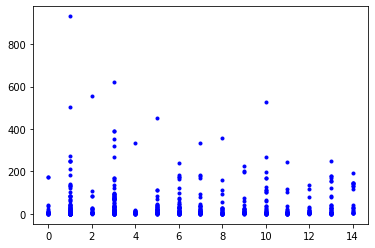

(5, 0.9681375)
(10, 0.982687)
(14, 0.96343833)
(7, 0.98635733)
(4, 0.40682057)
(4, 0.9634134)
(3, 0.9857929)
(3, 0.9508046)
(3, 0.98992646)
(0, 0.9857917)
(12, 0.9791774)
(8, 0.9783531)
(9, 0.97535706)
(15, 0.96643436)
(9, 0.976452)
(11, 0.9296626)
(5, 0.9942995)
(2, 0.9861865)
(6, 0.98645216)
(9, 0.9753567)
(1, 0.9912677)
(1, 0.9456022)
(8, 0.982603)
(4, 0.9861834)
(1, 0.9685864)
(7, 0.93856287)
(5, 0.905136)
(1, 0.95859444)
(12, 0.97917736)
(12, 0.9496095)
(12, 0.99347395)
(11, 0.985451)
(7, 0.93043685)
(11, 0.98200643)
(1, 0.9885853)
(14, 0.97917086)
(6, 0.9864519)
(2, 0.9783133)
(3, 0.9824323)
(6, 0.990245)
(14, 0.9910614)
(3, 0.9720181)
(4, 0.9657644)
(8, 0.98750865)
(12, 0.98199505)
(7, 0.97858137)
(1, 0.9456166)
(0, 0.7421369)
(5, 0.9847343)
(3, 0.97590315)
(9, 0.95404655)
(6, 0.9389826)
(14, 0.99676436)
(9, 0.9807217)
(8, 0.984159)
(3, 0.9895217)
(7, 0.985993)
(8, 0.98070914)
(14, 0.92960185)
(1, 0.20439889)
(8, 0.97135645)
(10, 0.9775435)
(3, 0.9720181)
(4, 0.982566)
(5, 0.971

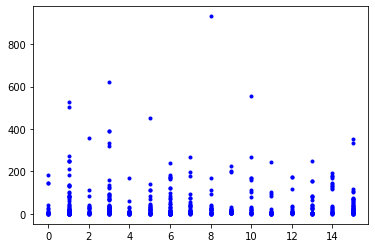

(16, 0.96707505)
(10, 0.9821131)
(3, 0.9631293)
(7, 0.9859006)
(9, 0.9563578)
(8, 0.9623195)
(0, 0.316509)
(12, 0.94804144)
(3, 0.76414573)
(0, 0.9853227)
(3, 0.9031498)
(0, 0.9775584)
(8, 0.9745401)
(1, 0.9652042)
(9, 0.97568613)
(10, 0.9278438)
(5, 0.9940703)
(2, 0.04155264)
(3, 0.98606765)
(3, 0.9750826)
(11, 0.16761541)
(5, 0.94269913)
(8, 0.9820338)
(0, 0.985702)
(1, 0.96729755)
(6, 0.9369923)
(8, 0.90154845)
(1, 0.956907)
(8, 0.97852117)
(4, 0.94785935)
(13, 0.9932928)
(11, 0.9850063)
(15, 0.9284161)
(11, 0.9814586)
(15, 0.9880974)
(14, 0.97839886)
(6, 0.98598695)
(9, 0.9776627)
(3, 0.9818299)
(1, 0.9898809)
(15, 0.99089426)
(3, 0.72578514)
(1, 0.96520305)
(11, 0.9871201)
(12, 0.9814157)
(6, 0.9780062)
(11, 0.9427573)
(0, 0.6737909)
(8, 0.98411244)
(12, 0.9745256)
(9, 0.952586)
(12, 0.93593246)
(14, 0.9966426)
(9, 0.9800919)
(8, 0.98363984)
(3, 0.98915994)
(7, 0.9855239)
(8, 0.98007923)
(10, 0.9278499)
(3, 0.9439023)
(7, 0.9707216)
(5, 0.976718)
(9, 0.97045034)
(8, 0.9820327)
(1,

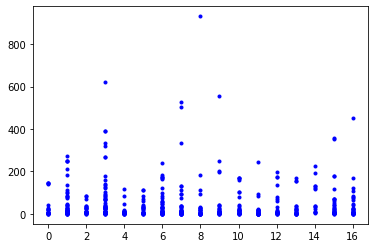

(3, 0.9666024)
(12, 0.9815304)
(6, 0.96186393)
(7, 0.98550946)
(0, 0.9550294)
(8, 0.9612988)
(3, 0.1349278)
(12, 0.94666296)
(3, 0.989262)
(14, 0.9849032)
(12, 0.9779224)
(2, 0.9770123)
(15, 0.97423416)
(16, 0.9642347)
(1, 0.97540736)
(11, 0.9258649)
(5, 0.99391013)
(2, 0.98535115)
(9, 0.9854125)
(9, 0.97392607)
(1, 0.3518699)
(9, 0.9413176)
(8, 0.7300041)
(13, 0.9854519)
(7, 0.96629554)
(1, 0.93532515)
(13, 0.89962935)
(6, 0.955812)
(12, 0.9779223)
(8, 0.94668484)
(17, 0.9930893)
(11, 0.98461527)
(0, 0.9254229)
(11, 0.9809769)
(17, 0.9876341)
(13, 0.9780628)
(6, 0.51948184)
(16, 0.97732145)
(13, 0.9810302)
(6, 0.98961455)
(3, 0.9907045)
(13, 0.9698045)
(2, 0.96374655)
(8, 0.9867404)
(1, 0.98122007)
(6, 0.97737044)
(14, 0.9408455)
(5, 0.9761002)
(8, 0.9836735)
(12, 0.9738324)
(9, 0.9514397)
(12, 0.9342534)
(16, 0.99661136)
(9, 0.97959685)
(8, 0.98318803)
(9, 0.9886485)
(7, 0.9851229)
(8, 0.979531)
(14, 0.92526513)
(9, 0.20633158)
(2, 0.96959466)
(10, 0.9762305)
(9, 0.9697212)
(8, 0.981

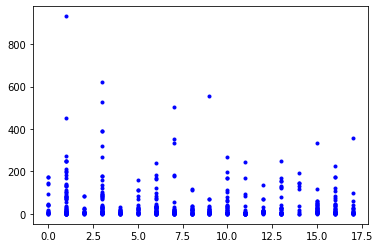

(3, 0.9661522)
(10, 0.9812846)
(13, 0.96087885)
(7, 0.9851987)
(9, 0.9544113)
(8, 0.9606418)
(13, 0.7158344)
(7, 0.9461102)
(2, 0.62136567)
(14, 0.9846513)
(7, 0.9776811)
(6, 0.79681605)
(15, 0.9737546)
(6, 0.96365714)
(9, 0.97458136)
(10, 0.92467415)
(5, 0.9938082)
(3, 0.9854436)
(3, 0.93895966)
(3, 0.97398275)
(18, 0.9904059)
(4, 0.93995446)
(8, 0.98121864)
(4, 0.985062)
(7, 0.96558523)
(18, 0.9335307)
(13, 0.8980457)
(6, 0.955011)
(11, 0.9775254)
(8, 0.94579446)
(17, 0.9929579)
(11, 0.9842796)
(16, 0.92485666)
(11, 0.98056287)
(18, 0.9874612)
(14, 0.9774559)
(2, 0.98509604)
(18, 0.9767565)
(3, 0.9810225)
(18, 0.98933095)
(17, 0.99035954)
(17, 0.96911126)
(9, 0.96317685)
(8, 0.9865097)
(1, 0.98079115)
(11, 0.9766126)
(1, 0.9408031)
(18, 0.9757729)
(15, 0.9836193)
(7, 0.9735498)
(13, 0.9507664)
(6, 0.9340896)
(14, 0.99649334)
(9, 0.979184)
(8, 0.9828965)
(3, 0.98867446)
(7, 0.98480463)
(8, 0.9791775)
(2, 0.9243385)
(4, 0.3514146)
(0, 0.968968)
(15, 0.97597945)
(7, 0.9692871)
(8, 0.981

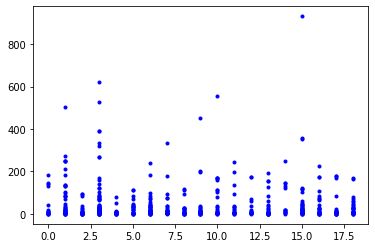

In [8]:
words = corpora.Dictionary(doc_list)

# Turns each document into a bag of words.
corpus = [words.doc2bow(doc) for doc in doc_list]

for i in range(2, 20):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=words,
                                                num_topics=i,
                                                random_state=2,
                                                update_every=1,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)

    corpus_transformed = lda_model[corpus]

    for elem in corpus_transformed:
        print(elem[0][0])

    x_topic = []
    y_topic_react = []

    for i in range(len(df_facebook['POSTS'])):
        x_topic.append(corpus_transformed[i][0][0][0])
        y_topic_react.append(int(df_facebook['ALL_REACTIONS'][i]))

    x_topic_array = np.array(x_topic)
    y_topic_react_array = np.array(y_topic_react)
    plt.plot(x_topic_array, y_topic_react_array, 'b.')
    plt.show()